In [1]:
# module import

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler

import numpy as np
import torchvision

from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

import time
import os
import copy

C:\Users\jjong\AppData\Local\Temp\ipykernel_29280\1698808647.py:14: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
import urllib.request
urllib.request.urlretrieve("https://download.pytorch.org/tutorial/hymenoptera_data.zip", "hymenoptera_data.zip")

('hymenoptera_data.zip', <http.client.HTTPMessage at 0x1dc44879350>)

In [6]:
import zipfile

with zipfile.ZipFile("hymenoptera_data.zip", 'r') as zip_ref:
    zip_ref.extractall(".")

## Data Preprocessing

In [7]:
data_transforms = {'train':transforms.Compose([transforms.RandomResizedCrop(224),
                                               transforms.RandomHorizontalFlip(),
                                               transforms.ToTensor(),
                                               transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
                                               
                    'val':transforms.Compose([transforms.Resize(256),
                                              transforms.CenterCrop(224),
                                              transforms.ToTensor(),
                                              transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])}

In [8]:
data_dir = './hymenoptera_data'
image_datasets = {x : datasets.ImageFolder(os.path.join(data_dir, x),
                                           data_transforms[x])
                for x in ['train', 'val']}

dataloaders = {x : DataLoader(image_datasets[x], batch_size=4, num_workers=4, shuffle=True) for x in ['train','val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}
class_names = image_datasets['train'].classes

In [9]:
print(class_names)

['ants', 'bees']


## Load for Transfer Learning Model

In [10]:
model_fit = models.resnet18(pretrained=True)

c:\Users\jjong\anaconda3\envs\jjong\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\jjong\anaconda3\envs\jjong\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
model_fit

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

- 데이터의 클래스 수에 맞게 out_features 변경

In [12]:
num_ftrs = model_fit.fc.in_features
model_fit.fc = nn.Linear(num_ftrs, 2)

model_fit = model_fit.to(device)

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_fit.parameters(), lr=1e-3, momentum=0.9)

In [15]:
# 7 epochs 마다 0.1씩 학습률 감소 시킴

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

## Model Training

In [19]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-'*10)

        for phase in ['train','val']:
            if phase == 'train' :
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss : {:.4f}\tAccuracy: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsesd = time.time() - since
    print('Training time : {:.0f}m {:.0f}s'.format(time_elapsesd // 60, time_elapsesd % 60))
    print('Best Validation ACC : {:.4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

In [20]:
model_fit=train_model(model_fit, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


c:\Users\jjong\anaconda3\envs\jjong\Lib\site-packages\torch\optim\lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train Loss : 0.6256	Accuracy: 0.6926
val Loss : 0.2081	Accuracy: 0.9216

Epoch 1/24
----------
train Loss : 0.4798	Accuracy: 0.8156
val Loss : 0.5125	Accuracy: 0.8366

Epoch 2/24
----------
train Loss : 0.5163	Accuracy: 0.8156
val Loss : 0.2517	Accuracy: 0.8758

Epoch 3/24
----------
train Loss : 0.8212	Accuracy: 0.6926
val Loss : 0.3009	Accuracy: 0.8889

Epoch 4/24
----------
train Loss : 0.7687	Accuracy: 0.7459
val Loss : 0.4007	Accuracy: 0.8954

Epoch 5/24
----------
train Loss : 0.7465	Accuracy: 0.7623
val Loss : 0.8006	Accuracy: 0.7712

Epoch 6/24
----------
train Loss : 0.4333	Accuracy: 0.8279
val Loss : 0.2514	Accuracy: 0.8954

Epoch 7/24
----------
train Loss : 0.5729	Accuracy: 0.7992
val Loss : 0.4640	Accuracy: 0.8758

Epoch 8/24
----------
train Loss : 0.4981	Accuracy: 0.8238
val Loss : 0.3952	Accuracy: 0.8562

Epoch 9/24
----------
train Loss : 0.5070	Accuracy: 0.7910
val Loss : 0.3242	Accuracy: 0.8954

Epoch 10/24
----------
train Loss : 0.4308	Accuracy: 0.8238
val Loss : 0

## 결과 시각화

In [21]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.cpu().numpy()
    fig = plt.figure(figsize=(10,5))
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

In [22]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images //2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted : {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
                
    model.train(mode=was_training)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


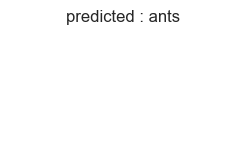

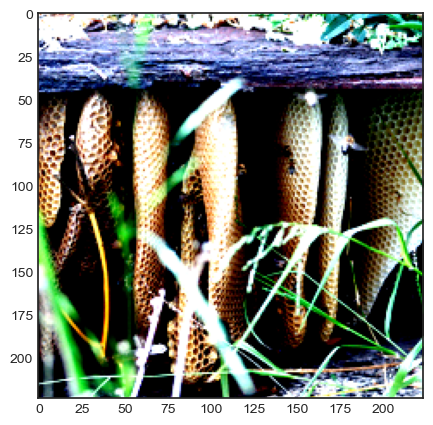

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


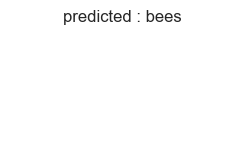

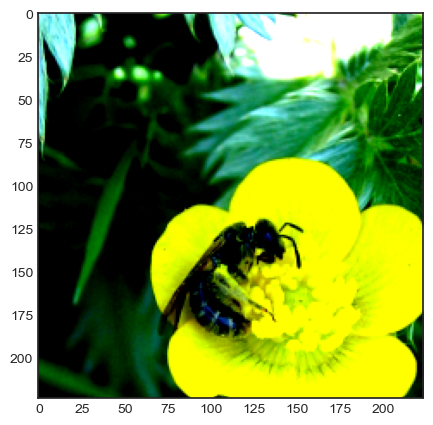

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


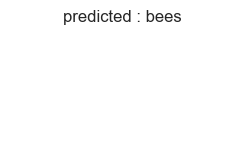

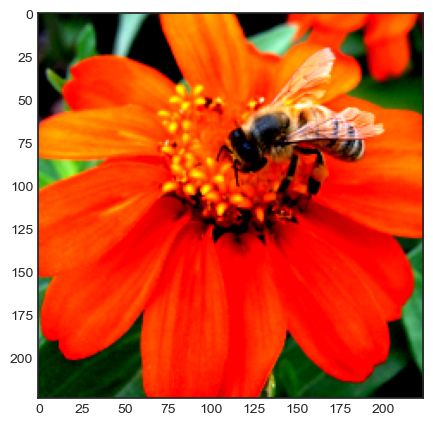

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


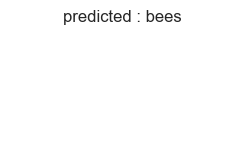

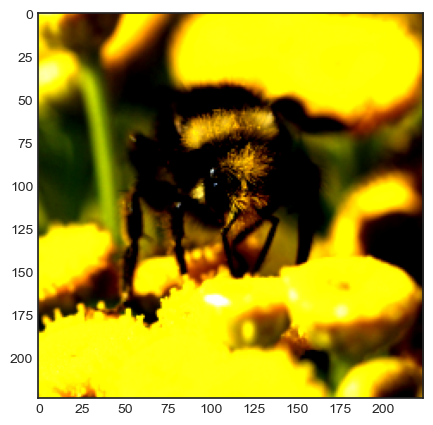

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


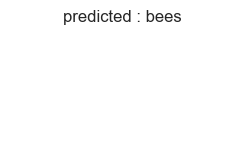

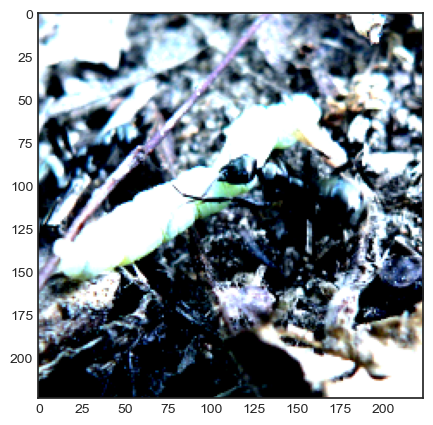

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


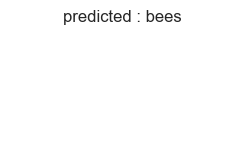

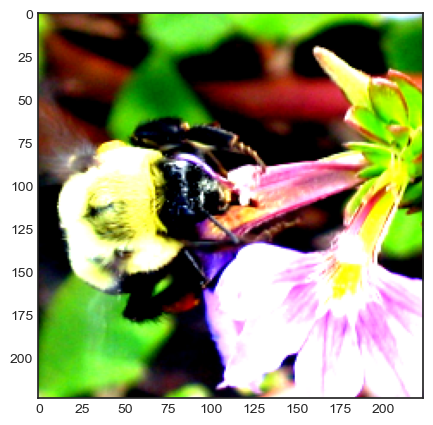

In [23]:
visualize_model(model_fit)

## 고정된 특징 추출기로써의 합성곱 신경망

- 마지막 계층을 제외한 신경망의 모든 부분을 고정
- requires_grad == False 로 설정하여 매개변수를 고정하여 backward() 중에 경사도가 계산되지 않도록 한다.

In [24]:
model_conv = torchvision.models.resnet18(pretrained=True)

for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.parameters(), lr=1e-3, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=0.7, gamma=0.1)

c:\Users\jjong\anaconda3\envs\jjong\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\jjong\anaconda3\envs\jjong\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [25]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss : 0.6119	Accuracy: 0.6557
val Loss : 0.6569	Accuracy: 0.7190

Epoch 1/24
----------
train Loss : 0.4986	Accuracy: 0.7705
val Loss : 0.3003	Accuracy: 0.8627

Epoch 2/24
----------
train Loss : 0.4619	Accuracy: 0.7828
val Loss : 0.1740	Accuracy: 0.9542

Epoch 3/24
----------
train Loss : 0.5020	Accuracy: 0.7869
val Loss : 0.1912	Accuracy: 0.9412

Epoch 4/24
----------
train Loss : 0.3950	Accuracy: 0.8197
val Loss : 0.1757	Accuracy: 0.9477

Epoch 5/24
----------
train Loss : 0.3929	Accuracy: 0.8525
val Loss : 0.1770	Accuracy: 0.9412

Epoch 6/24
----------
train Loss : 0.4254	Accuracy: 0.8115
val Loss : 0.3768	Accuracy: 0.8562

Epoch 7/24
----------
train Loss : 0.4717	Accuracy: 0.7664
val Loss : 0.1768	Accuracy: 0.9412

Epoch 8/24
----------
train Loss : 0.4963	Accuracy: 0.7992
val Loss : 0.2419	Accuracy: 0.9346

Epoch 9/24
----------
train Loss : 0.3708	Accuracy: 0.8320
val Loss : 0.1995	Accuracy: 0.9412

Epoch 10/24
----------
train Loss : 0.3872	Accurac

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


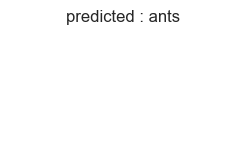

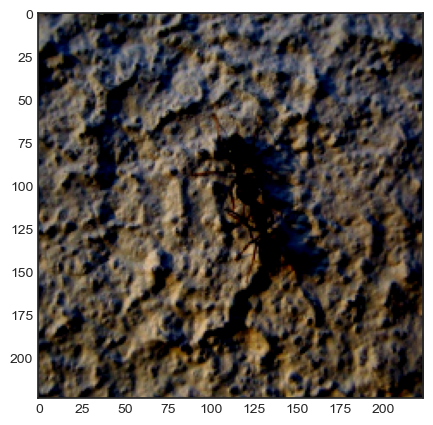

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


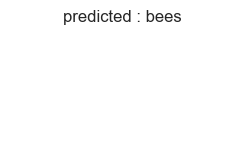

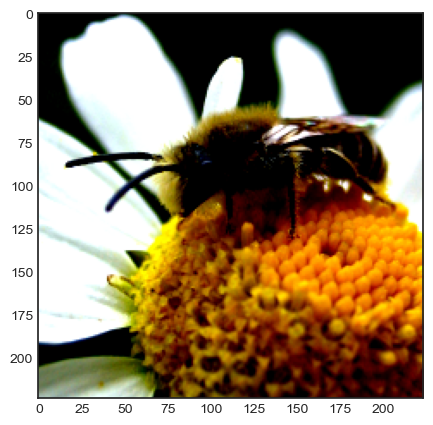

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


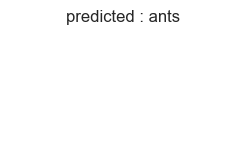

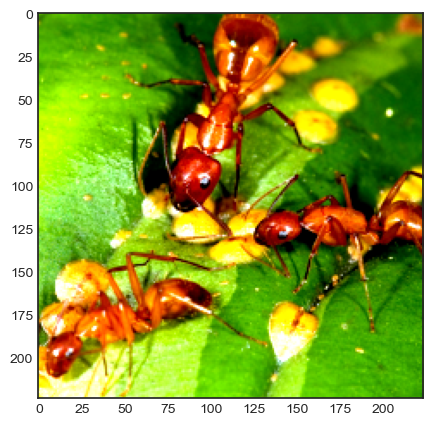

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


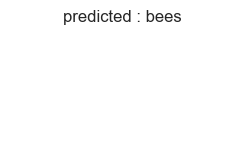

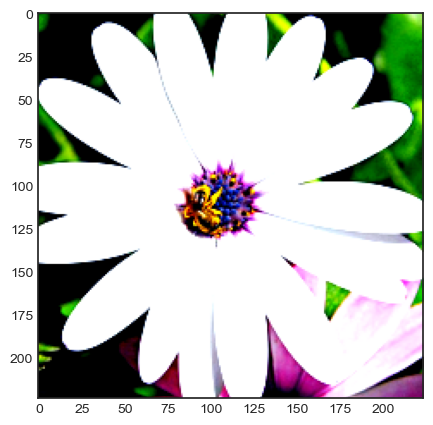

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


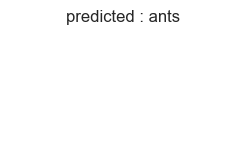

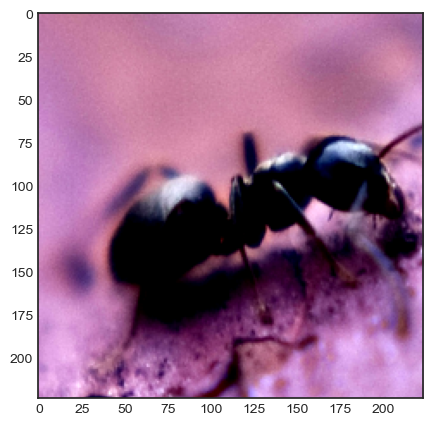

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


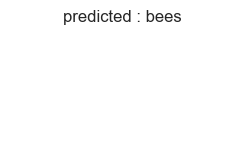

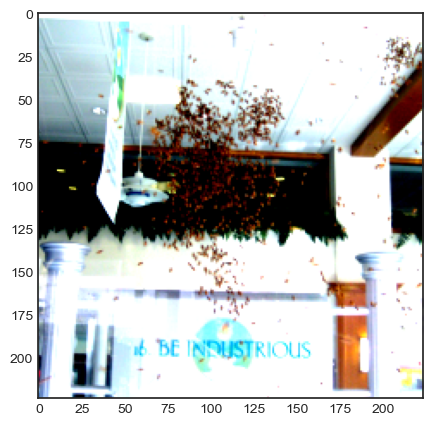

In [26]:
visualize_model(model_conv)